In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

df = pd.read_csv(r"C:\Users\ralph\OneDrive\Desktop\jupyter\datainterpretation\data\devices-report-batt-signal.csv", encoding='utf-8-sig')
df.head()
df.info()
df.describe()

ModuleNotFoundError: No module named 'google'

In [2]:
df.columns

Index(['time', 'Temperature 1', 'Battery 1', 'Signal 1', 'Temperature 2',
       'Battery 2', 'Signal 2', 'Temperature 3', 'Battery 3', 'Signal 3',
       ...
       'Signal 37', 'Temperature 38', 'Battery 38', 'Signal 38',
       'Temperature 39', 'Battery 39', 'Signal 39', 'Temperature 40',
       'Battery 40', 'Signal 40'],
      dtype='object', length=121)

# sort time

In [3]:
df.rename(columns={df.columns[0]: "time"}, inplace=True)
df.columns = df.columns.str.strip().str.replace(" ", "_")
df['time'] = pd.to_datetime(df['time'], format='%B %d, %Y %I:%M %p', errors='coerce')
df = df.sort_values('time').reset_index(drop=True)

# detect

In [4]:
signal_cols = [col for col in df.columns if 'Signal' in col]
signal_changes = df[['time'] + signal_cols].copy()

for col in signal_cols:
    signal_changes[col + '_lost'] = (df[col].shift(1) > 0) & (df[col] == 0)

loss_dates = {}
for col in signal_cols:
    lost_times = df.loc[signal_changes[col + '_lost'], 'time']
    if not lost_times.empty:
        loss_dates[col] = lost_times.iloc[0]

# event data frame

In [5]:
events = []

for col in signal_cols:
    df[f'prev_{col}'] = df[col].shift(1)
    
    lost_rows = df[(df[f'prev_{col}'] > 0) & (df[col] == 0)][['time']]
    lost_rows = lost_rows.assign(Device=col, Status='Lost Signal')
    
    gained_rows = df[(df[f'prev_{col}'] == 0) & (df[col] > 0)][['time']]
    gained_rows = gained_rows.assign(Device=col, Status='Gained Signal')
    
    events.append(pd.concat([lost_rows, gained_rows]))

# Combine all events

In [6]:
events_df = pd.concat(events).sort_values('time').reset_index(drop=True)

# Detect gateway update
### if many devices change signal at the same timestamp, mark as potential gateway update

In [7]:
THRESHOLD_RATIO = 0.1
threshold = max(5, int(len(signal_cols) * THRESHOLD_RATIO))
events_count = events_df.groupby('time').size().reset_index(name='Count')
events_df = events_df.merge(events_count, on='time')

events_df['Gateway_Update_Flag'] = events_df['Count'] >= threshold


# Preview event log

In [8]:
print(events_df.head(20))

                  time     Device         Status  Count  Gateway_Update_Flag
0  2025-09-11 20:38:00  Signal_35  Gained Signal      1                False
1  2025-09-11 21:20:00  Signal_16  Gained Signal      1                False
2  2025-09-11 21:24:00  Signal_28  Gained Signal      2                False
3  2025-09-11 21:24:00  Signal_17  Gained Signal      2                False
4  2025-09-11 21:25:00  Signal_29  Gained Signal      1                False
5  2025-09-11 21:26:00  Signal_15  Gained Signal      1                False
6  2025-09-11 21:27:00  Signal_34  Gained Signal      1                False
7  2025-09-11 21:28:00  Signal_13  Gained Signal      3                False
8  2025-09-11 21:28:00  Signal_32  Gained Signal      3                False
9  2025-09-11 21:28:00  Signal_36  Gained Signal      3                False
10 2025-09-11 21:33:00  Signal_37  Gained Signal      1                False
11 2025-09-11 21:38:00  Signal_18  Gained Signal      1                False

# Group by date to see daily summary

In [9]:
events_df['date'] = events_df['time'].dt.date
daily_summary = events_df.groupby(['date', 'Status']).size().unstack(fill_value=0)
daily_summary['Gateway_Update'] = events_df.groupby('date')['Gateway_Update_Flag'].max()
print(daily_summary)

Status      Gained Signal  Lost Signal  Gateway_Update
date                                                  
2025-09-11             12            0           False
2025-09-12              0           13            True
2025-09-15             18           19            True
2025-09-16             20            0            True
2025-09-18              1            1           False
2025-09-19             73           87            True
2025-09-20              1            2           False
2025-09-21              0            3           False
2025-09-22              6            2           False
2025-09-23              3            2           False
2025-09-24              1            0           False
2025-09-26             23           26            True
2025-09-27              1            0           False
2025-09-28              0            1           False
2025-09-29             22           25            True
2025-09-30              1            0           False


# most date with the highest lost signal

Date with most Lost Signal: 2025-09-19
Date with most Gained Signal: 2025-09-19

Daily Summary:
Status        date  Gained Signal  Lost Signal
0       2025-09-11             12            0
1       2025-09-12              0           13
2       2025-09-15             18           19
3       2025-09-16             20            0
4       2025-09-18              1            1
5       2025-09-19             73           87
6       2025-09-20              1            2
7       2025-09-21              0            3
8       2025-09-22              6            2
9       2025-09-23              3            2
10      2025-09-24              1            0
11      2025-09-26             23           26
12      2025-09-27              1            0
13      2025-09-28              0            1
14      2025-09-29             22           25
15      2025-09-30              1            0


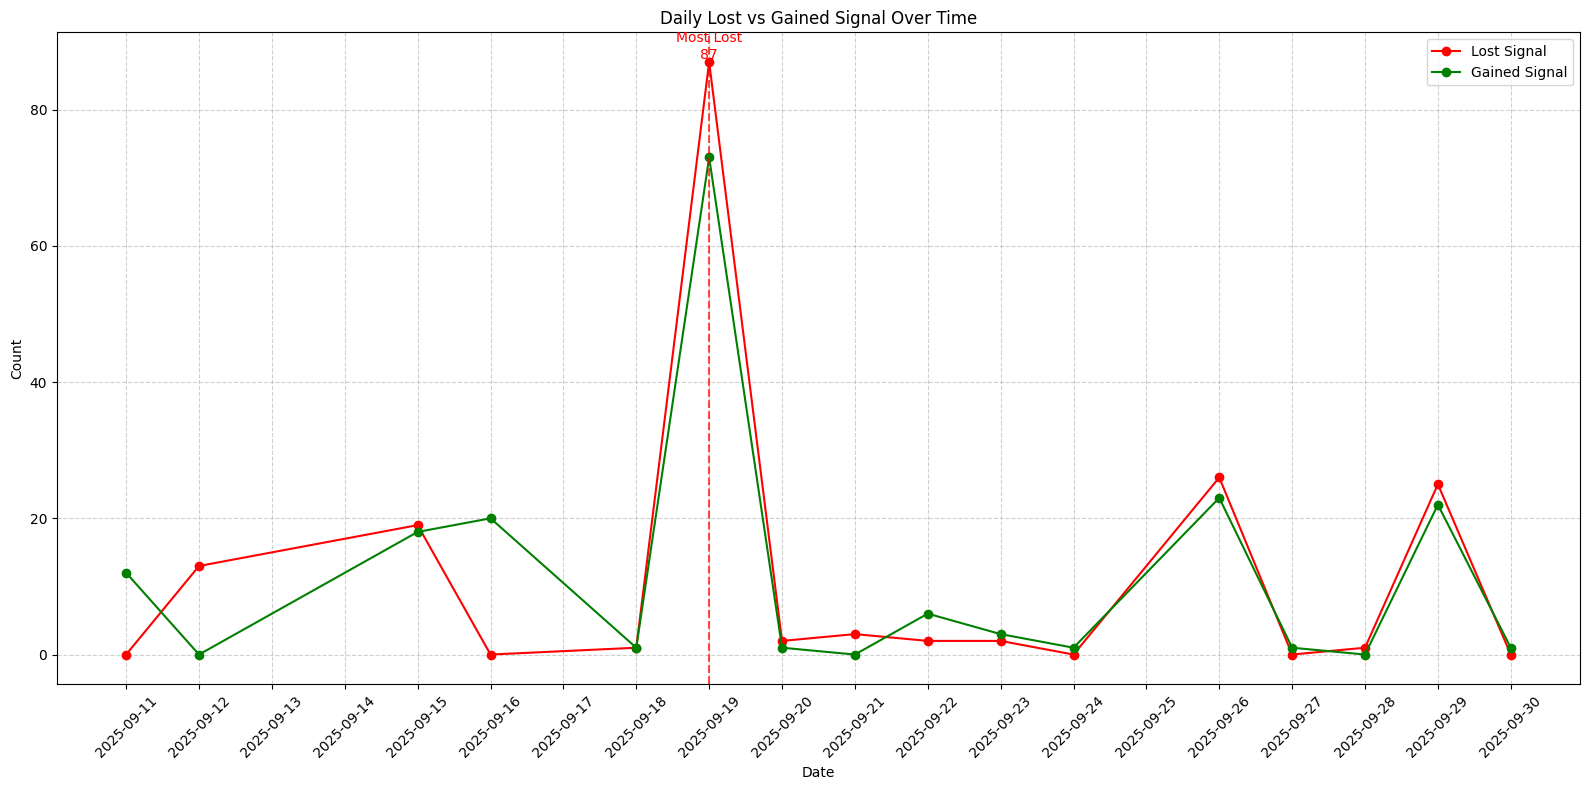

In [10]:
events = []

for col in signal_cols:
    df[f'prev_{col}'] = df[col].shift(1)
    
    # Lost: was >0, now 0
    lost_rows = df[(df[f'prev_{col}'] > 0) & (df[col] == 0)][['time']]
    lost_rows = lost_rows.assign(Device=col, Status='Lost Signal')
    
    # Gained: was 0, now >0
    gained_rows = df[(df[f'prev_{col}'] == 0) & (df[col] > 0)][['time']]
    gained_rows = gained_rows.assign(Device=col, Status='Gained Signal')
    
    events.append(pd.concat([lost_rows, gained_rows]))

# --- Combine all events ---
events_df = pd.concat(events).sort_values('time').reset_index(drop=True)

# --- Create daily summary ---
events_df['date'] = events_df['time'].dt.date
daily_summary = events_df.groupby(['date', 'Status']).size().unstack(fill_value=0)
daily_summary = daily_summary.reset_index()

# --- Identify the date with most lost signals ---
most_lost_date = daily_summary.loc[daily_summary['Lost Signal'].idxmax(), 'date']
most_gained_date = daily_summary.loc[daily_summary['Gained Signal'].idxmax(), 'date']

print("Date with most Lost Signal:", most_lost_date)
print("Date with most Gained Signal:", most_gained_date)
print("\nDaily Summary:")
print(daily_summary)

# --- Plot ---
most_lost_date = daily_summary.loc[daily_summary['Lost Signal'].idxmax(), 'date']
most_lost_count = daily_summary['Lost Signal'].max()

plt.figure(figsize=(16,8))
plt.plot(daily_summary['date'], daily_summary['Lost Signal'], color='red', marker='o', label='Lost Signal')
plt.plot(daily_summary['date'], daily_summary['Gained Signal'], color='green', marker='o', label='Gained Signal')

plt.title("Daily Lost vs Gained Signal Over Time")
plt.xlabel("Date")
plt.ylabel("Count")

# --- Show more dates on x-axis ---
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# --- Highlight the date with most lost signals ---
plt.axvline(pd.to_datetime(most_lost_date), color='red', linestyle='--', alpha=0.7)
plt.text(pd.to_datetime(most_lost_date), most_lost_count + 0.5,
         f'Most Lost\n{most_lost_count}', color='red', fontsize=10, ha='center')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# When devices most frequently gain and lost signals

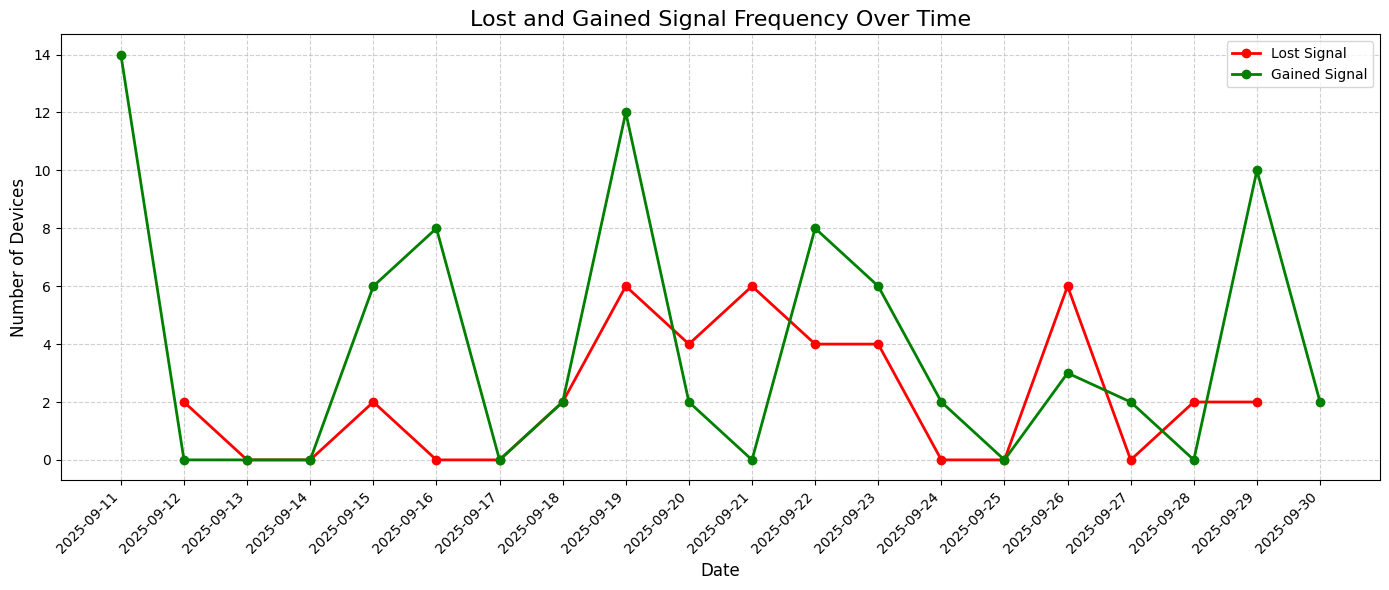

In [11]:
# --- Identify signal columns ---
signal_cols = [col for col in df.columns if 'Signal' in col]

lost_mask = df[signal_cols].lt(df[signal_cols].shift()) & df[signal_cols].eq(0)
gained_mask = df[signal_cols].gt(df[signal_cols].shift()) & df[signal_cols].shift().eq(0)

# --- Count rows with any lost/gained event across all devices ---
df['Lost'] = lost_mask.any(axis=1)
df['Gained'] = gained_mask.any(axis=1)

# --- Count lost/gained events per day ---
lost_per_day = df[df['Lost']].resample('D', on='time').size()
gained_per_day = df[df['Gained']].resample('D', on='time').size()

# --- Plot both ---
plt.figure(figsize=(14, 6))
plt.plot(lost_per_day.index, lost_per_day.values, color='red', marker='o', linewidth=2, label='Lost Signal')
plt.plot(gained_per_day.index, gained_per_day.values, color='green', marker='o', linewidth=2, label='Gained Signal')

plt.title("Lost and Gained Signal Frequency Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Devices", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# --- Format x-axis ---
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.legend()
plt.tight_layout()
plt.show()

# what time of day devices most often lose signal

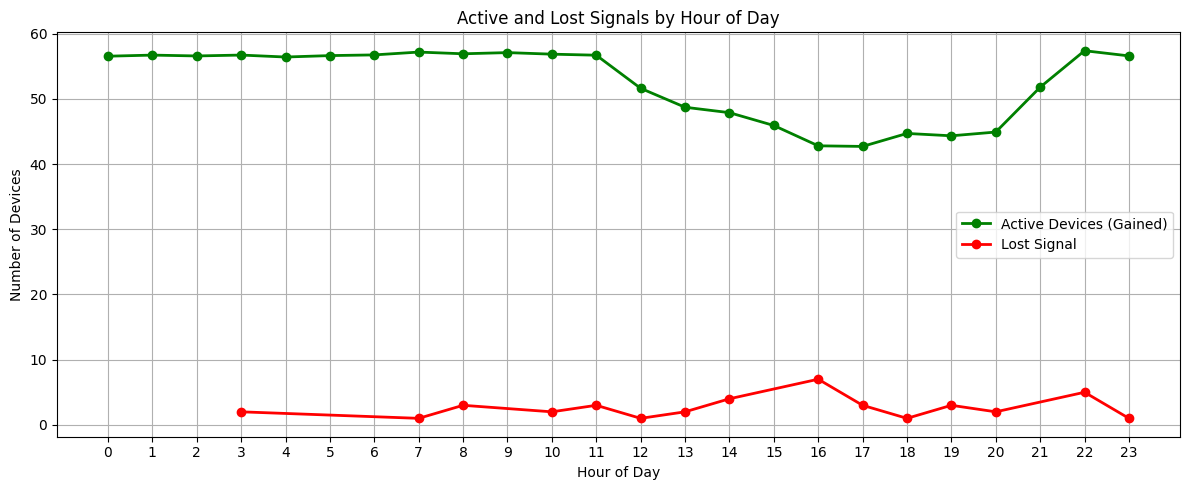

In [12]:
# --- Select all Signal columns ---
signal_cols = [col for col in df.columns if "Signal" in col]

# --- Count active devices (Signal > 0) per time ---
df['active_devices'] = df[signal_cols].gt(0).sum(axis=1)

# --- Detect lost signals (when a signal drops from >0 to 0) ---
lost_mask = df[signal_cols].lt(df[signal_cols].shift()) & df[signal_cols].eq(0)
df['lost_devices'] = lost_mask.any(axis=1)

# --- Count lost devices per hour ---
df['hour'] = df['time'].dt.hour
lost_per_hour = df[df['lost_devices']].groupby('hour').size().reset_index(name='lost_count')

# --- Average active devices per hour ---
avg_active = df.groupby('hour')['active_devices'].mean().reset_index()

# --- Plot both ---
plt.figure(figsize=(12, 5))

# Green line: gained / active devices
plt.plot(avg_active['hour'], avg_active['active_devices'], marker='o', linewidth=2, color='green', label='Active Devices (Gained)')

# Red line: lost devices
plt.plot(lost_per_hour['hour'], lost_per_hour['lost_count'], marker='o', linewidth=2, color='red', label='Lost Signal')

plt.title("Active and Lost Signals by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Devices")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
print(df['time'].head())


0   2025-09-11 15:23:00
1   2025-09-11 15:24:00
2   2025-09-11 15:25:00
3   2025-09-11 15:26:00
4   2025-09-11 15:27:00
Name: time, dtype: datetime64[ns]


# Lost & Gained Signals by Hour of Day (Simple Insight)

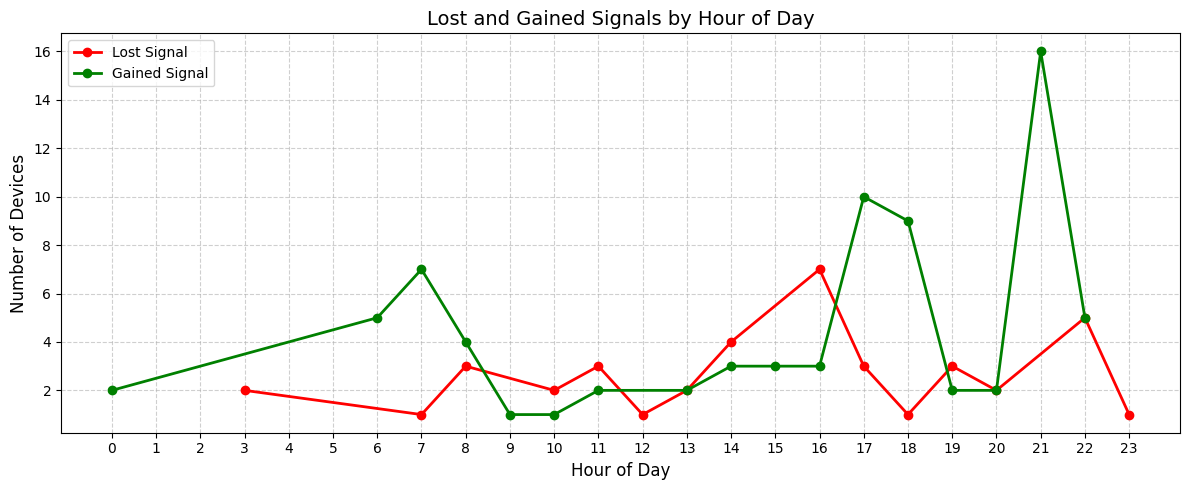

In [14]:
# --- Clean column names (remove spaces and standardize names) ---
df.rename(columns={df.columns[0]: "time"}, inplace=True)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# --- Convert time column to datetime ---
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values('time')

# --- Select all Signal columns ---
signal_cols = [col for col in df.columns if "Signal" in col]

# --- Count active devices (Signal > 0) per time ---
df['active_devices'] = df[signal_cols].gt(0).sum(axis=1)

# --- Detect lost and gained signals (compare to previous row) ---
lost_mask = df[signal_cols].lt(df[signal_cols].shift()) & df[signal_cols].eq(0)
gained_mask = df[signal_cols].gt(df[signal_cols].shift()) & df[signal_cols].shift().eq(0)

df['lost_devices'] = lost_mask.any(axis=1)
df['gained_devices'] = gained_mask.any(axis=1)

# --- Extract hour of day ---
df['hour'] = df['time'].dt.hour

# --- Count lost and gained devices per hour ---
lost_per_hour = df[df['lost_devices']].groupby('hour').size().reset_index(name='lost_count')
gained_per_hour = df[df['gained_devices']].groupby('hour').size().reset_index(name='gained_count')

# --- Plot both ---
plt.figure(figsize=(12, 5))
plt.plot(lost_per_hour['hour'], lost_per_hour['lost_count'], marker='o', linewidth=2, color='red', label='Lost Signal')
plt.plot(gained_per_hour['hour'], gained_per_hour['gained_count'], marker='o', linewidth=2, color='green', label='Gained Signal')

plt.title("Lost and Gained Signals by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Devices", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# Average Signal Strength by Hour (Quality Insight)

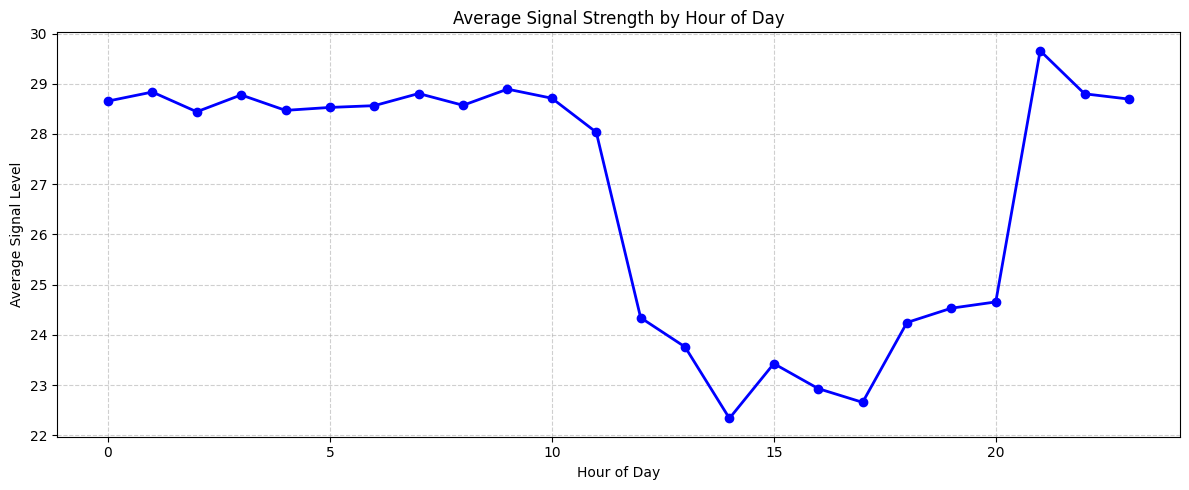

In [15]:
# --- Average signal strength by hour ---
df['hour'] = df['time'].dt.hour

signal_cols = [col for col in df.columns if "Signal" in col]
avg_signal_by_hour = df.groupby('hour')[signal_cols].mean().mean(axis=1).reset_index(name='Average_Signal')

plt.figure(figsize=(12,5))
plt.plot(avg_signal_by_hour['hour'], avg_signal_by_hour['Average_Signal'],
         marker='o', linewidth=2, color='blue')
plt.title("Average Signal Strength by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Signal Level")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Heatmap for Lost and Gained Signals

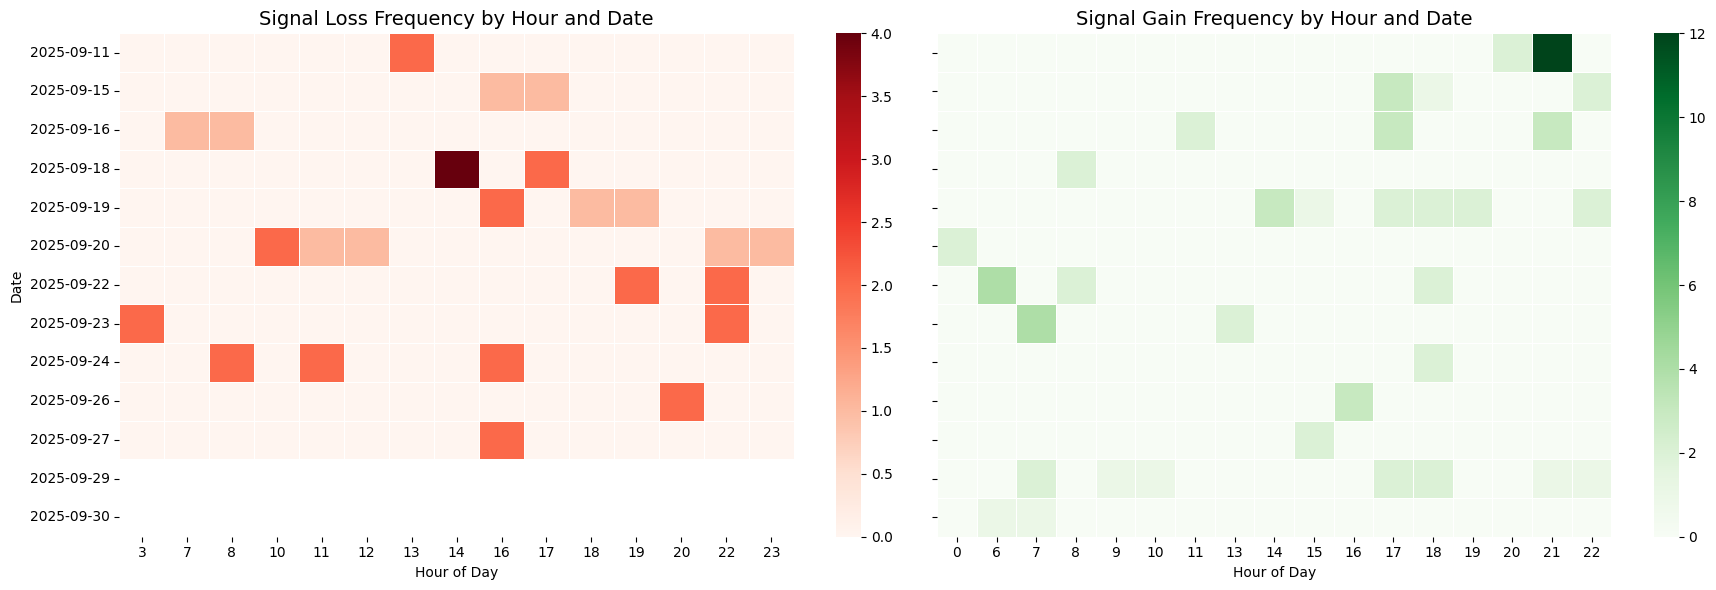

In [16]:
# --- Detect lost and gained signals ---
lost_mask = df[signal_cols].lt(df[signal_cols].shift()) & df[signal_cols].eq(0)
gained_mask = df[signal_cols].gt(df[signal_cols].shift()) & df[signal_cols].shift().eq(0)

df['Lost'] = lost_mask.any(axis=1)
df['Gained'] = gained_mask.any(axis=1)

# --- Extract date and hour ---
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour

# --- Aggregate counts per date-hour ---
lost_heatmap = df[df['Lost']].groupby(['date', 'hour']).size().unstack(fill_value=0)
gained_heatmap = df[df['Gained']].groupby(['date', 'hour']).size().unstack(fill_value=0)

# --- Plot both heatmaps side by side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.heatmap(lost_heatmap, cmap='Reds', linewidths=0.5, ax=axes[0])
axes[0].set_title("Signal Loss Frequency by Hour and Date", fontsize=14)
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Date")

sns.heatmap(gained_heatmap, cmap='Greens', linewidths=0.5, ax=axes[1])
axes[1].set_title("Signal Gain Frequency by Hour and Date", fontsize=14)
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()
